In [2]:
pip install torch higher

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import higher
import random
import matplotlib.pyplot as plt
import scipy.stats as stats

# Define transformations, models (BasicCNN and MAMLModel), and dataloaders

# Define the transformation of the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
full_trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
full_testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Define BasicCNN model for CIFAR-100
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 100)  # CIFAR-100 has 100 classes
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# DataLoader for CIFAR-100

trainloader = DataLoader(full_trainset, batch_size=4, shuffle=True, num_workers=2)
testloader = DataLoader(full_testset, batch_size=4, shuffle=False, num_workers=2)

# Define MAMLModel for FC100
class MAMLModel(nn.Module):
    def __init__(self):
        super(MAMLModel, self).__init__()
        # Define a similar architecture to BasicCNN but adapt it for MAML
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 500)
        self.fc2 = nn.Linear(500, 100)  # 100 classes in CIFAR-100
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# DataLoader for FC100

# Randomly select class indices for FC100 split
all_classes = list(range(100))
random.shuffle(all_classes)
fc100_train_classes = all_classes[:60]  # 60 classes for training
fc100_val_classes = all_classes[60:80]  # 20 classes for validation
fc100_test_classes = all_classes[80:]   # 20 classes for testing

def extract_classes(dataset, classes):
    class_idx = [idx for idx, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, class_idx)

# Extract the FC100 subsets
trainset_fc100 = extract_classes(full_trainset, fc100_train_classes)
valset_fc100 = extract_classes(full_trainset, fc100_val_classes)
testset_fc100 = extract_classes(full_testset, fc100_test_classes)

# DataLoaders for FC100
fc100_trainloader = DataLoader(trainset_fc100, batch_size=5, shuffle=True)
fc100_valloader = DataLoader(valset_fc100, batch_size=5, shuffle=True)
fc100_testloader = DataLoader(testset_fc100, batch_size=5, shuffle=False)

# Complete MAMLModel Definition for FC100 & Setting up the Training Loop for MAML

# Define the device for training (GPU if available)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyperparameters for MAML
inner_lr = 0.01  # Learning rate for task-specific (inner) updates
meta_lr = 0.001  # Learning rate for meta (outer) updates
num_inner_updates = 5  # Number of gradient updates for task adaptation
num_tasks = 4  # Number of tasks per meta-training batch
task_batch_size = 10  # Batch size for each task
num_epochs = 50  # Number of meta-training epochs

# Initialize MAML model and move to device
maml_model = MAMLModel().to(device)
meta_optimizer = optim.Adam(maml_model.parameters(), lr=meta_lr)

# Function to sample tasks for training
def sample_tasks(dataset, num_tasks, task_batch_size):
    all_indices = list(range(len(dataset)))
    random.shuffle(all_indices)
    tasks = [all_indices[i:i + task_batch_size] for i in range(0, len(all_indices), task_batch_size)]
    return [Subset(dataset, task_indices) for task_indices in tasks[:num_tasks]]

# MAML Training Loop
for epoch in range(num_epochs):
    maml_model.train()
    epoch_loss = 0.0

    tasks = sample_tasks(trainset_fc100, num_tasks, task_batch_size)

    for task in tasks:
        task_dataloader = DataLoader(task, batch_size=task_batch_size, shuffle=True)
        task_loss = 0.0

        # Inner loop for task-specific adaptation
        with higher.innerloop_ctx(maml_model, meta_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            for inner_step in range(num_inner_updates):
                for data, labels in task_dataloader:
                    data, labels = data.to(device), labels.to(device)
                    task_prediction = fmodel(data)
                    inner_loss = nn.CrossEntropyLoss()(task_prediction, labels)
                    diffopt.step(inner_loss)

            # Evaluate adapted model on the same task
            for data, labels in task_dataloader:
                data, labels = data.to(device), labels.to(device)
                task_prediction = fmodel(data)
                task_loss += nn.CrossEntropyLoss()(task_prediction, labels)

        epoch_loss += task_loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/num_tasks}')

100%|██████████| 169001437/169001437 [00:03<00:00, 48861590.73it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1/50, Loss: 2.806124448776245
Epoch 2/50, Loss: 2.7177078127861023
Epoch 3/50, Loss: 2.777456820011139
Epoch 4/50, Loss: 2.6378270983695984
Epoch 5/50, Loss: 2.644220292568207
Epoch 6/50, Loss: 2.805028796195984
Epoch 7/50, Loss: 2.6499692797660828
Epoch 8/50, Loss: 2.5801976919174194
Epoch 9/50, Loss: 2.5858570337295532
Epoch 10/50, Loss: 2.771274983882904
Epoch 11/50, Loss: 2.8460384607315063
Epoch 12/50, Loss: 2.7014419436454773
Epoch 13/50, Loss: 2.5644381046295166
Epoch 14/50, Loss: 2.5777008533477783
Epoch 15/50, Loss: 2.5767248272895813
Epoch 16/50, Loss: 2.6235647797584534
Epoch 17/50, Loss: 2.463948667049408
Epoch 18/50, Loss: 2.3971745371818542
Epoch 19/50, Loss: 2.5085909366607666
Epoch 20/50, Loss: 2.7464531660079956
Epoch 21/50, Loss: 2.562187671661377
Epoch 22/50, Loss: 2.6246275901794434
Epoch 23/50, Loss: 2.7056201100349426
Epoch 24/50, Loss: 2.652585029602051
Epoch 25/50, Lo

In [6]:
# Train BasicCNN on CIFAR-100

# Initialize the model
basic_cnn = BasicCNN()
basic_cnn.to(device)  # Move the model to the appropriate device (GPU/CPU)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(basic_cnn.parameters(), lr=0.001, momentum=0.9)

# Number of epochs for training
num_epochs = 10

# Lists to track the accuracy and loss for visualization
training_accuracies = []
training_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = basic_cnn(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate and print statistics for the epoch
    epoch_loss = running_loss / len(trainloader)
    epoch_accuracy = correct / total
    training_accuracies.append(epoch_accuracy)
    training_losses.append(epoch_loss)

    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training BasicCNN on CIFAR-100')

Epoch 1, Loss: 3.6828, Accuracy: 0.1399
Epoch 2, Loss: 2.8705, Accuracy: 0.2832
Epoch 3, Loss: 2.3937, Accuracy: 0.3837
Epoch 4, Loss: 2.0096, Accuracy: 0.4676
Epoch 5, Loss: 1.6378, Accuracy: 0.5520
Epoch 6, Loss: 1.2481, Accuracy: 0.6449
Epoch 7, Loss: 0.8749, Accuracy: 0.7411
Epoch 8, Loss: 0.5626, Accuracy: 0.8290
Epoch 9, Loss: 0.3973, Accuracy: 0.8761
Epoch 10, Loss: 0.2766, Accuracy: 0.9143
Finished Training BasicCNN on CIFAR-100


In [12]:
# Train MAMLModel on FC100

# Initialize the MAML model and move it to the device
maml_model = MAMLModel().to(device)

# Define the meta-optimizer (for outer loop updates)
meta_optimizer = optim.Adam(maml_model.parameters(), lr=0.001)

# Hyperparameters for MAML training
num_epochs = 50  # Total number of epochs for meta-training
num_tasks_per_batch = 4  # Number of tasks in each batch
task_batch_size = 5  # Number of samples per task
num_inner_updates = 5  # Number of gradient updates per task

# MAML Training Loop
for epoch in range(num_epochs):
    maml_model.train()
    meta_optimizer.zero_grad()

    epoch_loss = 0.0

    # Sample a batch of tasks
    tasks = sample_tasks(trainset_fc100, num_tasks_per_batch, task_batch_size)

    for task in tasks:
        task_dataloader = DataLoader(task, batch_size=task_batch_size, shuffle=True)

        # Inner loop: Task-specific adaptation
        with higher.innerloop_ctx(maml_model, meta_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            for _ in range(num_inner_updates):
                for data, labels in task_dataloader:
                    data, labels = data.to(device), labels.to(device)
                    task_pred = fmodel(data)
                    inner_loss = criterion(task_pred, labels)
                    diffopt.step(inner_loss)

            # Calculate loss for meta-update
            for data, labels in task_dataloader:
                data, labels = data.to(device), labels.to(device)
                task_pred = fmodel(data)
                task_loss = criterion(task_pred, labels)
                epoch_loss += task_loss

    # Normalize the loss
    normalized_loss = epoch_loss / (len(tasks) * len(task_dataloader))

    # Perform the meta-update
    normalized_loss.backward()  # Backpropagate the normalized loss
    meta_optimizer.step()

    print(f'Epoch {epoch + 1}/{num_epochs}, Meta Loss: {normalized_loss.item():.4f}')

print('Finished Training MAMLModel on FC100')

Epoch 1/50, Meta Loss: 1.9493
Epoch 2/50, Meta Loss: 2.2649
Epoch 3/50, Meta Loss: 2.2767
Epoch 4/50, Meta Loss: 1.6969
Epoch 5/50, Meta Loss: 1.8486
Epoch 6/50, Meta Loss: 1.4934
Epoch 7/50, Meta Loss: 1.7497
Epoch 8/50, Meta Loss: 1.4155
Epoch 9/50, Meta Loss: 1.5759
Epoch 10/50, Meta Loss: 1.1527
Epoch 11/50, Meta Loss: 1.4723
Epoch 12/50, Meta Loss: 1.2955
Epoch 13/50, Meta Loss: 1.0371
Epoch 14/50, Meta Loss: 0.8746
Epoch 15/50, Meta Loss: 0.8525
Epoch 16/50, Meta Loss: 0.8417
Epoch 17/50, Meta Loss: 0.8182
Epoch 18/50, Meta Loss: 0.9042
Epoch 19/50, Meta Loss: 0.7868
Epoch 20/50, Meta Loss: 1.0086
Epoch 21/50, Meta Loss: 1.0629
Epoch 22/50, Meta Loss: 0.8419
Epoch 23/50, Meta Loss: 0.7817
Epoch 24/50, Meta Loss: 0.7791
Epoch 25/50, Meta Loss: 1.0613
Epoch 26/50, Meta Loss: 0.8706
Epoch 27/50, Meta Loss: 1.0826
Epoch 28/50, Meta Loss: 1.0197
Epoch 29/50, Meta Loss: 0.8525
Epoch 30/50, Meta Loss: 0.8660
Epoch 31/50, Meta Loss: 0.7903
Epoch 32/50, Meta Loss: 1.1831
Epoch 33/50, Meta

In [13]:
# Evaluate both models

# Evaluate BasicCNN
basic_cnn.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():  # No gradients needed for evaluation
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = basic_cnn(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

cnn_accuracy = correct / total
print(f'Accuracy of BasicCNN on CIFAR-100: {cnn_accuracy * 100:.2f}%')

# Evaluate MAMLModel on FC100 Test Set

# Function to evaluate MAML model
def evaluate_maml_model(model, test_dataset, num_tasks, task_batch_size, num_adaptation_steps, device):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0

    # Sample tasks for evaluation
    tasks = sample_tasks(test_dataset, num_tasks, task_batch_size)

    for task in tasks:
        task_dataloader = DataLoader(task, batch_size=task_batch_size, shuffle=True)

        # Adapt the model to the current task
        with higher.innerloop_ctx(model, meta_optimizer, track_higher_grads=False) as (fmodel, diffopt):
            for adaptation_step in range(num_adaptation_steps):
                for data, labels in task_dataloader:
                    data, labels = data.to(device), labels.to(device)
                    task_prediction = fmodel(data)
                    inner_loss = criterion(task_prediction, labels)
                    diffopt.step(inner_loss)

            # Evaluate the adapted model on the same task
            with torch.no_grad():  # Disable gradient tracking for evaluation
                for data, labels in task_dataloader:
                    data, labels = data.to(device), labels.to(device)
                    task_prediction = fmodel(data)
                    _, predicted = torch.max(task_prediction, 1)
                    total_correct += (predicted == labels).sum().item()
                    total_samples += labels.size(0)

    return total_correct / total_samples

# Set the parameters for the evaluation
num_test_tasks = 20  # Number of test tasks
test_task_batch_size = 10  # Batch size per test task
num_adaptation_steps = 5  # Adaptation steps during testing

# Evaluate the MAMLModel
maml_accuracy = evaluate_maml_model(maml_model, testset_fc100, num_test_tasks, test_task_batch_size, num_adaptation_steps, device)
print(f'Accuracy of MAMLModel on FC100: {maml_accuracy * 100:.2f}%')

Accuracy of BasicCNN on CIFAR-100: 38.02%
Accuracy of MAMLModel on FC100: 62.00%


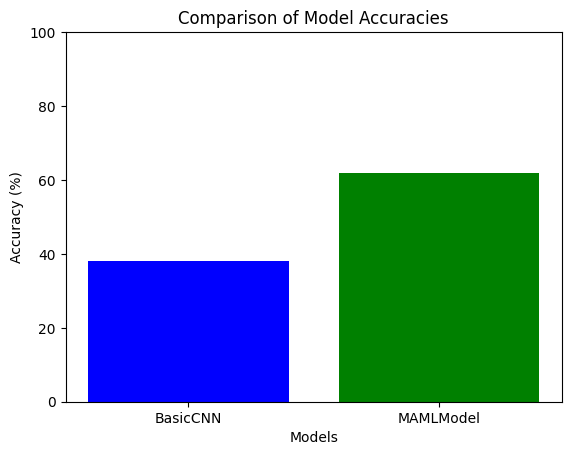

In [20]:
import matplotlib.pyplot as plt

# Assuming cnn_accuracy and maml_accuracy are already computed
accuracies = [cnn_accuracy * 100, maml_accuracy * 100]  # Convert to percentages
models = ['BasicCNN', 'MAMLModel']

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Model Accuracies')
plt.ylim([0, 100])  # Set the limits of the y-axis to 0-100 for percentage
plt.show()
